# Exploration

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import IPython.display as ipd

import torch
import time

import utils

In [14]:
AUDIO_DIR = 'data/fma_small'

tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [15]:
# Get fma_small metadata
small_tracks = tracks[tracks['set', 'subset'] <= 'small']
small_tracks.index

Int64Index([     2,      5,     10,    140,    141,    148,    182,    190,
               193,    194,
            ...
            153956, 154303, 154305, 154306, 154307, 154308, 154309, 154413,
            154414, 155066],
           dtype='int64', name='track_id', length=8000)

### You can load the waveform and listen to audio in the notebook itself.

In [106]:
filename = utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

'''
x => audio clip of the song saved as a numpy ndarray
sr => rate at which the song should be processed s.t. it sounds like a song
'''
x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 0, 30
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: data/fma_small/000/000002.mp3


/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.98s, 1321967 samples


And use librosa to compute spectrograms and audio features.

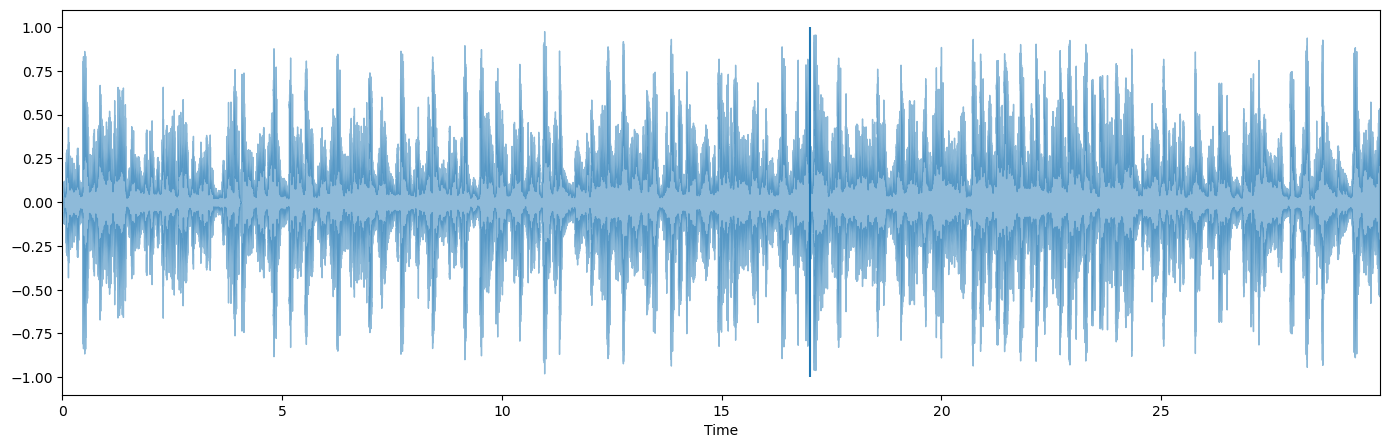

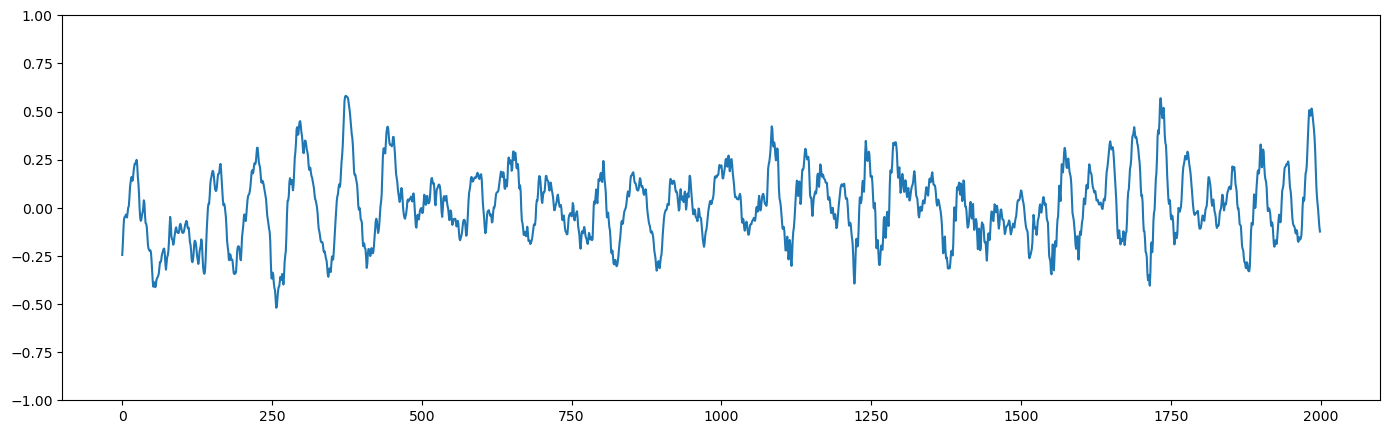

In [18]:
plt.rcParams['figure.figsize'] = (17, 5)

librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

## Genre Classification

In [23]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [24]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


# OUR ADDED CODE

Text(0.5, 0.98, 'Spectrogram')

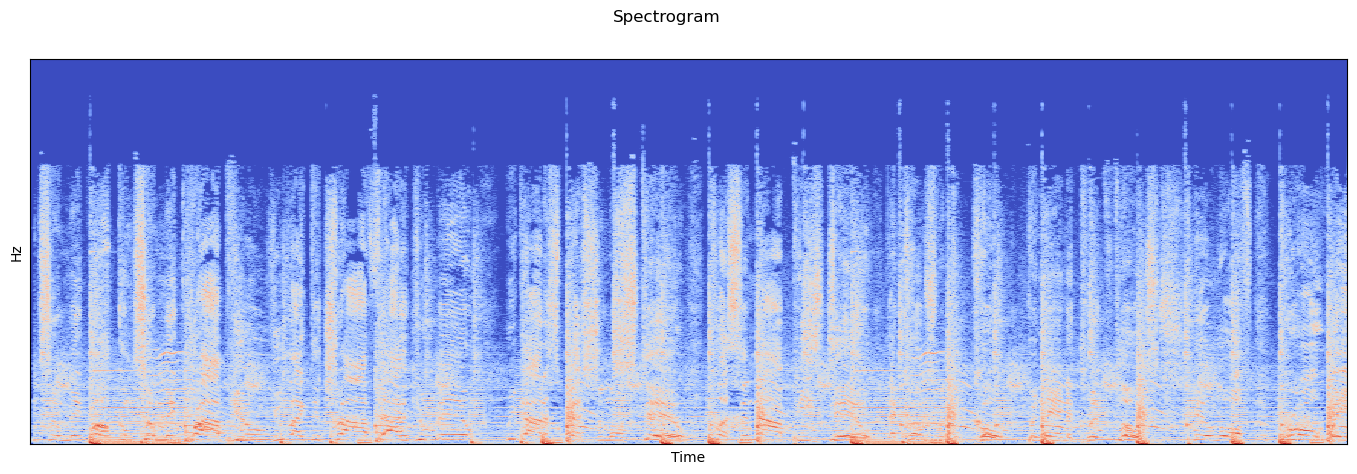

In [54]:
'''
CONVERTS OUR SONG INTO A 10 SECOND INTERVAL AND PLOTS A SPECTOGRAM

research amplitude_to_db

'''
absed = np.abs(librosa.stft(np.array(x[0*sr:10*sr])))
# plt.pcolormesh(absed)
dbed_sig = librosa.amplitude_to_db(absed)
librosa.display.specshow(dbed_sig)
plt.xlabel("Time")
plt.ylabel("Hz")
plt.suptitle("Spectrogram")

In [43]:
y_train.unique()

['International', 'Experimental', 'Rock', 'Instrumental', 'Folk', 'Hip-Hop', 'Electronic', 'Pop']
Categories (8, object): ['International', 'Experimental', 'Rock', 'Instrumental', 'Folk', 'Hip-Hop', 'Electronic', 'Pop']

### Convert one clip into n overlapping mel-spectrograms
Following this link:
https://stackoverflow.com/a/57204349

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


File: data/fma_small/000/000002.mp3
Num Samples: 1321967
881311
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
0.2217710018157959s


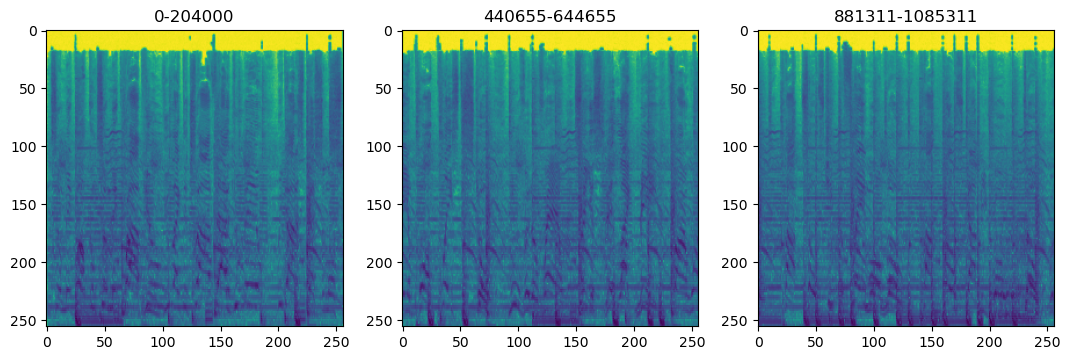

In [173]:
import deepdish as dd # used to save torch tensor as hdf5 file
# settings
n = 3 # number of spectrograms to generate
hop_length = 800 # number of samples per time-step in spectrogram
n_mels = 256 # number of bins in spectrogram. Height of image
time_steps = 255 # number of time-steps. Width of image - 1

mel_spectrograms = []

filename = utils.get_audio_path(AUDIO_DIR, 2)
try:
    y, sr = librosa.load(filename, sr=None, mono=True)
except Exception as e:
    print('error')

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

print(f'File: {filename}')
print(f'Num Samples: {x.size}')

fig = plt.figure(figsize=(13, 8))

t = np.ndarray((0, 1, 256, 256))
for i in range(n): # 0 1 2 3 4
    start = int(i / n * y.size)
    end = start + (time_steps * hop_length)
    window = y[start:end]
    
    mels = librosa.feature.melspectrogram(
        y=window, 
        sr=sr,
        n_mels=n_mels,
        n_fft=hop_length*2,
        hop_length=hop_length
    )
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)
    
    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy
    
    img = img[np.newaxis, ...]
    print(img.shape)
    
    t = np.concatenate((t, img[np.newaxis, ...]))
    
    ax = fig.add_subplot(1, n, i+1)
    ax.set_title(f'{start}-{end}')
    ax.imshow(np.transpose(img, (1, 2, 0)))
d = {'spectrograms': t }
dd.io.save('data/test_save.h5', d)
plt.show()

In [175]:
# Test that dict can be reconstructed from hdf5 file 
d = dd.io.load('test_save.h5')
d['spectrograms'].shape

(3, 1, 256, 256)

## Notes May 6:

### Proposed Architecture:

pre-process files into splitting each clip into x second intervals which might overlap we then feed into our model as spectograms or vectors

Potential complexities involving mixture of genres causing misclass. Effectively, if a 10 second clip is not representative of the genre its classifying to (because by splitting it into 10 second clips, we are going to label each 10 second clip by the og label of the 30 second clip)

If facing overfitting, try randomized intervals for songs.

In [196]:
from multiprocessing import Pool, set_start_method

X = {
    'training': np.ndarray((0, 1, 256, 256)), 
    'validation': np.ndarray((0, 1, 256, 256)), 
    'test': np.ndarray((0, 1, 256, 256)) 
} 
Y = {
    'training': np.ndarray((0, 8)),
    'validation': np.ndarray((0, 8)),
    'test': np.ndarray((0, 8))
}

def f(index):
    test = np.random.rand(1,1,256,256)
    return test

small_genres = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
def g(index):
    s = small_tracks.loc[index]['track', 'genre_top']
    bool_to_int = lambda b: 1 if b else 0
    s_arr = [bool_to_int(s == genre) for genre in small_genres]
    s_np = np.asarray(s_arr)

indices = tracks.loc[(tracks['set', 'subset'] <= 'small') & (tracks['set', 'split'] == 'training')].index
print('pooling')
set_start_method('spawn')
with Pool(5) as p:
    print('poolingX')
    X_arr = p.map(f, indices)
with Pool(5) as p:
    print('poolingY')
    Y_arr = p.map(g, indices)
    
print('concatenatingX')
X['training'] = np.concatenate(X_arr)
print('concatenatingY')
Y['training'] = np.concatenate(Y_arr)

print(X['training'].shape, Y['training'].shape)
print(Y['training'])

pooling


RuntimeError: context has already been set

RuntimeError: context has already been set

In [10]:
import numpy as np

t = np.random.rand(1, 256, 257)
print(t.shape)
t = t[:, :, (t.shape[2]-256):t.shape[2]]
print(t.shape)

(1, 256, 257)
(1, 256, 256)


In [20]:
s = small_tracks.loc[2]['track', 'genre_top']
small_genres = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
s_arr = [int(s == genre) for genre in small_genres]
s_np = np.asarray(s_arr)
s_np = s_np[np.newaxis, ...] # Change to (8,) -> (1, 8) for ease of np.concatenate

[array([[0, 0, 0, 1, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0, 0, 0, 0]])]